# Exam 2

Blake Green

CS 5393

# Model Setup and Descriptions

This  explains how the models are configured in the script and provides detailed descriptions of each one, including their parameter sizes and design considerations.

## Code Overview

The script is designed to automate the process of pulling several language models using the command-line tool `ollama`. It sets up a list of models and defines a function, `pull_model`, which uses Python's `subprocess` module to execute the `ollama pull` command for each specified model. Successful pulls or errors during this process are printed to the console.

### Key elements of the code:

- **Importing Libraries:**  
  Libraries such as `subprocess`, `psutil`, `json`, `pandas`, and modules from NLTK are imported. While some of these imports (like NLTK and pandas) might be used in other parts of the project, the main operation shown here is model pulling.

- **Model List:**  
  The models chosen are stored in a list:
  ```python
  models = ['phi', 'gemma:7b', 'llama2:13b']
  ```

- **Model Pulling:**  
  The `pull_model` function executes:
  ```python
  subprocess.run(['ollama', 'pull', model_name], check=True)
  ```
  which downloads the specified model for later use.

- **Execution Flow:**  
  The script iterates over the list of models and pulls each one in sequence:
  ```python
  if __name__ == "__main__":
      for model in models:
          pull_model(model)
  ```

## Model Descriptions

### phi

- **Description:**  
  The phi model is included for its unique set of capabilities designed for balanced performance and efficiency. The model is recognized for delivering competitive results in various language processing tasks while maintaining a moderate computational footprint.

- **Parameter Count:**  
  1.3 billion parameters.

### gemma:7b

- **Description:**  
  The gemma:7b model is a language model specifically optimized for resource efficiency while still delivering strong performance. Its parameter count makes it a suitable choice for environments where hardware resources are limited compared to very large language models.

- **Parameter Count:**  
  7 billion parameters

### llama2:13b

- **Description:**  
  The llama2:13b model belongs to Meta's LLaMA2 series. It is designed to provide robust language generation capabilities with a moderate computational requirement. This model is especially important as a replacement for the original llama3.3 model. Initially, llama3.3 (with approximately 3.3 times the parameters compared to the baseline models) was used for more expansive language tasks; however, it required significantly more computational resources, making it less feasible for local deployment.

- **Parameter Count:**  
  13 billion parameters

- **Replacement Note:**  
  Due to the high resource demands associated with llama3.3, the decision was made to replace it with llama2:13b in order to better align with local hardware capabilities while still offering high-quality performance. This change strikes a balance between maintaining robust language processing features and ensuring that the models can run efficiently on available systems.

## Resource Considerations

A key factor in choosing these models is the balance between performance and resource utilization:

- **Efficiency vs. Capability:**  
  While larger models (like the originally considered llama3.3) can offer enhanced performance, their substantial computational requirements can hinder local deployment.

- **Local Execution:**  
  Replacing llama3.3 with llama2:13b allows the workflow to maintain strong language generation abilities without overwhelming local hardware, ensuring that the solution remains accessible and practical for local testing and usage.


In [2]:
import subprocess
import time
import psutil
import json
import pandas as pd
import nltk
from nltk.corpus import gutenberg, reuters
import random
import threading
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import colorsys
from matplotlib.colors import to_rgb

models = ['phi', 'gemma:7b', 'llama2:13b']

def pull_model(model_name):
    try:
        print(f"Pulling model: {model_name}")
        subprocess.run(['ollama', 'pull', model_name], check=True)
        print(f"Successfully pulled {model_name}\n")
    except subprocess.CalledProcessError as e:
        print(f"Failed to pull {model_name}: {e}")

if __name__ == "__main__":
    for model in models:
        pull_model(model)


Pulling model: phi
Successfully pulled phi

Pulling model: gemma:7b
Successfully pulled gemma:7b

Pulling model: llama2:13b
Successfully pulled llama2:13b



This code defines a function `run_model` that does two main things:  
1. **Runs a model process using a subprocess.**  
2. **Monitors the process’s resource usage (memory and CPU) during its execution.**

Below is a detailed explanation of how it works:

### 1. Running the Model

- **Starting the Subprocess:**  
  The code uses the `subprocess.Popen` call to start an external model command (e.g., an Ollama model) with the provided `model_name`. It sets up the subprocess with pipes for standard input, output, and error:

  ```python
  popen_proc = subprocess.Popen(
      ['ollama', 'run', model_name],
      stdin=subprocess.PIPE,
      stdout=subprocess.PIPE,
      stderr=subprocess.PIPE
  )

- **Sending Input and Receiving Output:**
  A helper function `run_communicate` is defined, which calls `popen_proc.communicate` with the encoded prompt. This function reads the output and error streams from the subprocess and stores them in the result dictionary.

- **Using a Thread for Communication:**
Instead of blocking the main thread, a new thread (`comm_thread`) is started to run `run_communicate`. This allows the main thread to continuously monitor resource usage while the model is executing in the background.

  ```python
  comm_thread = threading.Thread(target=run_communicate)
  comm_thread.start()
  
### 2. Measuring Resource Usage
- **Process Initialization:**
  The code wraps the subprocess in a `psutil.Process` object, which allows for monitoring system-level metrics like memory and CPU usage. It even attempts to catch a possible `NoSuchProcess` exception.

- **Measuring Memory and CPU:**
  The function `get_total_memory_and_cpu` computes the total memory (using RSS value) and total CPU usage for the subprocess and all its child processes. This ensures that if the model spawns additional processes, their resource usage is also accounted for.

  ```python
  def get_total_memory_and_cpu(proc):
    try:
        total_mem = proc.memory_info().rss
        total_cpu = proc.cpu_percent(interval=None)
        for child in proc.children(recursive=True):
            try:
                total_mem += child.memory_info().rss
                total_cpu += child.cpu_percent(interval=None)
            except psutil.NoSuchProcess:
                continue
        return total_mem, total_cpu
    except psutil.NoSuchProcess:
        return 0, 0
        
- **CPU Counter Warm-Up:**
  Before entering the monitoring loop, the code calls `cpu_percent()` on both the main process and its children. This “warms-up” the CPU usage counters to provide a baseline reading for subsequent measurements.

- **Resource Monitoring Loop:**
  While the model’s subprocess communication is still running (checked by `comm_thread.is_alive()`), the loop:
  * Fetches current memory and CPU usage.
  * Converts memory from bytes to megabytes.
  * Tracks the maximum memory and CPU usage observed during the process lifetime.

  ```python
  while comm_thread.is_alive():
    if proc:
        total_mem, total_cpu = get_total_memory_and_cpu(proc)
        current_mb = total_mem / (1024 ** 2)
        max_memory_usage_MB = max(max_memory_usage_MB, current_mb)
        if track_cpu:
            max_cpu_usage_percent = max(max_cpu_usage_percent, total_cpu)
    time.sleep(0.05)
    
### 3. Returning the Results
After the monitoring loop finishes:
* The communication thread is joined to ensure it has completed.
* The total elapsed time is calculated.
* A dictionary is returned with the following keys:
  * `"output"`: The decoded standard output of the model.
  * `"error"`: The decoded error messages.
  * `"time"`: Total execution time.

In [4]:
def run_model(model_name, prompt, track_cpu=True):
    start_time = time.time()

    # Start the Ollama subprocess
    popen_proc = subprocess.Popen(
        ['ollama', 'run', model_name],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )

    result = {}

    # Function to communicate with the process
    def run_communicate():
        out, err = popen_proc.communicate(input=prompt.encode())
        result['out'] = out
        result['err'] = err

    # Start communication in a background thread
    comm_thread = threading.Thread(target=run_communicate)
    comm_thread.start()

    try:
        proc = psutil.Process(popen_proc.pid)
    except psutil.NoSuchProcess:
        proc = None

    max_memory_usage_MB = 0
    max_cpu_usage_percent = 0.0

    def get_total_memory_and_cpu(proc):
        try:
            total_mem = proc.memory_info().rss
            total_cpu = proc.cpu_percent(interval=None)
            for child in proc.children(recursive=True):
                try:
                    total_mem += child.memory_info().rss
                    total_cpu += child.cpu_percent(interval=None)
                except psutil.NoSuchProcess:
                    continue
            return total_mem, total_cpu
        except psutil.NoSuchProcess:
            return 0, 0

    # Give CPU counters a warm-up reading
    if track_cpu:
        proc.cpu_percent()
        for child in proc.children(recursive=True):
            child.cpu_percent()

    while comm_thread.is_alive():
        if proc:
            total_mem, total_cpu = get_total_memory_and_cpu(proc)
            current_mb = total_mem / (1024 ** 2)
            max_memory_usage_MB = max(max_memory_usage_MB, current_mb)
            if track_cpu:
                max_cpu_usage_percent = max(max_cpu_usage_percent, total_cpu)
        time.sleep(0.05)

    comm_thread.join()
    duration = time.time() - start_time

    return {
        "output": result.get('out', b'').decode('utf-8'),
        "error": result.get('err', b'').decode('utf-8'),
        "time": duration,
        "mem_usage_MB": round(max_memory_usage_MB, 2),
        "cpu_usage_percent": round(max_cpu_usage_percent, 2) if track_cpu else None
    }


# Task Initilization

This part is organized to define various task prompts for different natural language processing challenges. It covers four main task categories: general knowledge questions, text summarization tasks, code generation tasks, and creative writing prompts.

## 1. General Knowledge Questions

A dictionary named `general_qa_tasks` is created, which contains four simple general knowledge questions:
- **General QA 1:** "What is the capital of France?"
- **General QA 2:** "What is the largest planet in our solar system?"
- **General QA 3:** "Who wrote '1984'?"
- **General QA 4:** "What is the boiling point of water in Celsius?"

Each task in the dictionary is identified by a unique key and paired with its corresponding question as the value.

## 2. Text Summarization Tasks

Before defining the summarization prompts, the code downloads two NLTK corpora:
- **Reuters Corpus**: A collection of news articles.
- **Gutenberg Corpus**: A collection of texts that includes classic literature.

These corpora are well documented and can be found at [NLTK Book Chapter 2](https://www.nltk.org/book/ch02.html).

### Reuters Corpus
- **Downloading & Selecting the Article:**  
  The Reuters corpus is downloaded using `nltk.download('reuters')`.  
  A specific news article is selected using its file ID `"training/6083"`, which corresponds to the article titled *"ZAMBIAN EXCHANGE AUCTION TO RESUME AT END OF MARCH"*.
- **Extracting an Excerpt:**  
  The full text of the article is read into the variable `news_text_full`, and an excerpt (first 2000 characters) is stored in `news_text_excerpt` for demonstration purposes.

### Gutenberg Corpus
- **Downloading & Selecting the Text:**  
  The Gutenberg corpus is downloaded using `nltk.download('gutenberg')`.  
  A short story is extracted from the file `bryant-stories.txt`.  
- **Extracting an Excerpt:**  
  A specific section of the text is sliced between character indices 430 and 2775, and the excerpt is stored in `short_story_excerpt`.

These excerpts are then used to define two summarization tasks in the `text_summarization_tasks` dictionary, each prompting the summarization of the provided text.

## 3. Simple Code Generation Tasks

A dictionary named `code_gen_tasks` is established with three prompts that require writing Python functions:
- **Code Generation 1:** Write a Python function that checks if a number is prime.
- **Code Generation 2:** Write a Python function to compute the factorial of a number using recursion.
- **Code Generation 3:** Write a Python function that reverses a given string.

These prompts are designed to test or demonstrate basic programming skills.

## 4. Creative Writing Prompts

Lastly, the `creative_writing_tasks` dictionary contains two prompts aimed at encouraging creative writing:
- **Creative Writing 1:** Write a short story about a robot discovering emotions for the first time.
- **Creative Writing 2:** Write a poem about the beauty of nature and technology merging.

In [6]:
# ## General Knowledge Questions (4 prompts)
general_qa_tasks = {
    "General QA 1": "What is the capital of France?",
    "General QA 2": "What is the largest planet in our solar system?",
    "General QA 3": "Who wrote '1984'?",
    "General QA 4": "What is the boiling point of water in Celsius?"
}

# ## Text Summarization Tasks (2 prompts with larger texts)

nltk.download('gutenberg')
nltk.download('reuters')

# --- News Article from Reuters Corpus ---
# We use Reuters file ID "training/6083", which corresponds to the article titled
# "ZAMBIAN EXCHANGE AUCTION TO RESUME AT END OF MARCH".
news_text_full = reuters.raw("training/6083")
# Slice the text for demonstration purposes (e.g., first 2000 characters).
news_text_excerpt = news_text_full[:2000]

# --- Short Story from Gutenberg Corpus ---
# We extract a section representing the short story "THE LITTLE YELLOW TULIP" from the 
# "bryant-stories.txt" file.
# The text is sliced between character indices 430 and 2775 for demonstration purposes.
short_story_text_full = gutenberg.raw('bryant-stories.txt')
short_story_excerpt = short_story_text_full[430:2775]

text_summarization_tasks = {
    "Summarization 1": "Summarize the following news article:\n" + news_text_excerpt,
    "Summarization 2": "Summarize the following short story:\n" + short_story_excerpt
}

# ## Simple Code Generation Tasks (3 prompts)
code_gen_tasks = {
    "Code Generation 1": "Write a Python function that checks if a number is prime.",
    "Code Generation 2": "Write a Python function to compute the factorial of a number using recursion.",
    "Code Generation 3": "Write a Python function that reverses a given string."
}

# ## Creative Writing Prompts (2 prompts)
creative_writing_tasks = {
    "Creative Writing 1": "Write a short story about a robot discovering emotions for the first time.",
    "Creative Writing 2": "Write a poem about the beauty of nature and technology merging."
}


[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\blake\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\blake\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [7]:
print(news_text_excerpt)

ZAMBIAN EXCHANGE AUCTION TO RESUME AT END OF MARCH
  Zambia will reintroduce a modified
  foreign exchange auction at the end of this month as part of a
  new two-tier exchange rate, central bank governor Leonard
  Chivuno said.
      Chivuno told a press conference at the end of three weeks
  of negotiations with the International Monetary Fund (IMF) that
  there would be a fixed exchange rate for official transactions
  and a fluctuating rate, decided by the auction, for other types
  of business.
      The Bank of Zambia previously held weekly auctions to
  distribute foreign exchange to the private sector and determine
  the kwacha's exchange rate, but these were suspended at the end
  of January.
      President Kenneth Kaunda said at the time that he was
  suspending the auction system in view of the rapid devaluation
  and violent fluctations of the exchange rate which had
  resulted.
      Business and banking sources said another reason for
  suspending the auction was that th

In [8]:
print(short_story_excerpt)



THE LITTLE YELLOW TULIP


Once there was a little yellow Tulip, and she lived down in a little
dark house under the ground. One day she was sitting there, all by
herself, and it was very still. Suddenly, she heard a little _tap, tap,
tap_, at the door.

"Who is that?" she said.

"It's the Rain, and I want to come in," said a soft, sad, little voice.

"No, you can't come in," the little Tulip said.

By and by she heard another little _tap, tap, tap_ on the window-pane.

"Who is there?" she said.

The same soft little voice answered, "It's the Rain, and I want to come
in!"

"No, you can't come in," said the little Tulip.

Then it was very still for a long time. At last, there came a little
rustling, whispering sound, all round the window: _rustle, whisper,
whisper_.

"Who is there?" said the little Tulip.

"It's the Sunshine," said a little, soft, cheery voice, "and I want to
come in!"

"N--no," said the little Tulip, "you can't come in." And she sat still
again.

Pretty soon she heard

## General Question Answering Tasks

In [10]:
results = {}

for model in models:
    print(f"\n=== Running General QA tasks for model: {model} ===")
    
    # Ensure that the results dictionary is set up for General QA tasks for this model.
    if model not in results:
        results[model] = {}
    if "General QA" not in results[model]:
        results[model]["General QA"] = {}

    # Execute each general QA task
    for task_name, prompt in general_qa_tasks.items():
        print(f"\nTask: {task_name}")
        output_data = run_model(model, prompt)
        results[model]["General QA"][task_name] = {
            "Prompt": prompt,
            "Output": output_data["output"],
            "Time (s)": output_data["time"],
            "Memory Usage (MB)": output_data["mem_usage_MB"],
            "CPU Usage (%)": output_data["cpu_usage_percent"]
        }
        print("Output:\n", output_data["output"])



=== Running General QA tasks for model: phi ===

Task: General QA 1
Output:
  The capital of France is Paris. It's located in the north-central part of the country, just south of Lake Paris.




Task: General QA 2
Output:
  The largest planet in our solar system is Jupiter. It has a diameter of approximately 86,881 miles (139,822 kilometers), which is more than 11 times the diameter of Earth. Jupiter's mass is also much larger than all the other planets combined. It is so massive that its gravity holds onto most of the objects in the asteroid belt between Mars and Jupiter, including some dwarf planets such as Ceres.




Task: General QA 3
Output:
  As an AI language model, I do not have access to information about individual works of literature or authors. However, if you are referring to the year 1994, then the novel '1844' by Tom Clancy is set in that time period and its title refers to the year 1844.




Task: General QA 4
Output:
  The boiling point of water at sea level is 100 de

## Analysis and Comparison of Model Responses - General QA
- **Accuracy:**  
  - **gemma:7b** and **llama2:13b** consistently provided accurate and succinct answers for all tasks.  
  - **phi** delivered correct answers for three out of the four tasks (Tasks 1, 2, and 4) but failed on Task 3, where it gave an irrelevant and misleading response.

- **Detail and Verbosity:**  
  - **phi** is notably more verbose, adding contextual details and additional information that, while sometimes educational (as in Task 2 and Task 4), could also introduce potential inaccuracies (as seen in Task 1 with the inaccurate geographic detail - "Lake Paris").
  - **gemma:7b** and **llama2:13b** favor brevity and clarity, answering directly without unnecessary embellishments.

- **Style:**  
  - **gemma:7b** uses markdown formatting (bold text) to emphasize key parts of the answer.
  - **llama2:13b** adheres to a plain, straightforward text style.
  - **phi** attempts to be explanatory but, due to its extra verbosity, runs the risk of deviating from accuracy.

---


## Text Summarization Tasks

In [17]:
for model in models:
    print(f"\n=== Running Summarization tasks for model: {model} ===")
    
    # Ensure that the results dictionary is set up for Summarization tasks for this model.
    if model not in results:
        results[model] = {}
    if "Summarization" not in results[model]:
        results[model]["Summarization"] = {}

    # Execute each text summarization task
    for task_name, prompt in text_summarization_tasks.items():
        print(f"\nTask: {task_name}")
        output_data = run_model(model, prompt)
        results[model]["Summarization"][task_name] = {
            "Prompt": prompt,
            "Output": output_data["output"],
            "Time (s)": output_data["time"],
            "Memory Usage (MB)": output_data["mem_usage_MB"],
            "CPU Usage (%)": output_data["cpu_usage_percent"]
        }
        print("Output:\n", output_data["output"])



=== Running Summarization tasks for model: phi ===

Task: Summarization 1
Output:
  The foreign exchange auction system will resume at the end of March with a two-tier exchange rate, where there is a fixed exchange rate for official transactions and a fluctuating rate determined by an auction for other business transactions. This change was agreed upon during negotiations between Zambia's central bank governor, Leonard Chivuno, and the International Monetary Fund (IMF) over three weeks ago. The auctions were previously suspended in January due to rapid devaluation and violent fluctuations of the exchange rate. President Kenneth Kaunda suspended the auction system while the central bank was low on foreign exchange and 10 weeks behind in paying successful bidders.




Task: Summarization 2
Output:
  This short story is about a little yellow tulip who lives in a dark house under the ground. One day, she hears the rain and wants to let it in, but refuses. She then hears the sunshine, whic

## Analysis of Model Performance on Summarization Tasks - Text Summarization
- **Fidelity to the Source:**  
  - All three models correctly identify and convey the main points of both the news article and the short story. However, llama2:13b sometimes introduces extraneous details (e.g., mentioning "decline in copper prices"), which can lead to minor deviations from the original source.

- **Brevity vs. Detail:**  
  - **gemma:7b** is the most concise and structured, providing essential information without superfluous details.
  - **phi** strikes a balance between detail and brevity, offering a clear summary while remaining factual.
  - **llama2:13b** provides the most comprehensive summaries, but its extra commentary and additional context might be considered unnecessary in a pure summarization task.

- **Stylistic Considerations:**  
  - **phi** maintains a neutral, factual tone suited for formal summaries.
  - **gemma:7b** utilizes markdown formatting to enhance clarity, making its output easy to scan.
  - **llama2:13b** uses a more conversational style that could either make the summary engaging or introduce informal elements that detract from the summarization purpose.

Each model exhibits strengths depending on the desired use case:  
- For precision and conciseness, **gemma:7b** might be preferred.  
- For balanced detail with a neutral tone, **phi** performs well.  
- For a thorough, conversational summary that mirrors narrative progression closely, **llama2:13b** stands out despite its occasional extra details.

## Code Generation Tasks

In [18]:
for model in models:
    print(f"\n=== Running Code Generation tasks for model: {model} ===")
    
    # Ensure that the results dictionary is set up for Code Generation tasks for this model.
    if model not in results:
        results[model] = {}
    if "Code Generation" not in results[model]:
        results[model]["Code Generation"] = {}

    # Execute each code generation task
    for task_name, prompt in code_gen_tasks.items():
        print(f"\nTask: {task_name}")
        output_data = run_model(model, prompt)
        results[model]["Code Generation"][task_name] = {
            "Prompt": prompt,
            "Output": output_data["output"],
            "Time (s)": output_data["time"],
            "Memory Usage (MB)": output_data["mem_usage_MB"],
            "CPU Usage (%)": output_data["cpu_usage_percent"]
        }
        print("Output:\n", output_data["output"])



=== Running Code Generation tasks for model: phi ===

Task: Code Generation 1
Output:
  def is_prime(n):
    # check if n is less than 2 or even, then it's not prime
    if n < 2 or (n % 2 == 0 and n != 2):
        return False

    # check for odd numbers from 3 to the square root of n with a step of 2
    for i in range(3, int(n**0.5) + 1, 2):
        if n % i == 0:
            return False

    # if we make it this far, then the number is prime
    return True




Task: Code Generation 2
Output:
  def factorial(n): 
    if n == 1 or n == 0: 
        return 1
    else: 
        return n * factorial(n-1)

The function `factorial()` takes in a positive integer 'n' and returns its factorial using recursion. If the input is 0 or 1, it returns 1; otherwise, it multiplies the input by the result of calling itself with a reduced value of n until reaching 1.



In the world of AI programming languages, there are three major ones: Java, Python, and C++. Each language has its own unique featu

# Analysis and Comparison of Model Responses - Code Generation
- **Clarity and Readability:**  
  - **Gemma:7b** excels in documentation; its detailed docstrings, example usages, and complexity analyses enhance comprehension.
  - **Llama2:13b** adopts a concise style, delivering clear explanations with minimal extraneous detail.
  - **Phi** produces correct and efficient code but, especially in Code Generation 2, sometimes extends its answer with extra contextual information.

- **Optimization and Efficiency:**  
  - In the prime-checking task, **phi** shows a slight performance edge by optimizing the loop (skipping even numbers), while **gemma:7b** and **llama2:13b** opt for simpler, more traditional solutions.
  
- **Creativity and Extended Explanations:**  
  - **Phi’s extension in Code Generation 2** stands out: it integrates an imaginative narrative comparing programming languages. This extension likely stems from phi’s design to add depth and creative context when it senses the prompt may benefit from further exploration, even if the task only required a basic factorial function.
  - **Gemma:7b’s** approach remains focused on thorough educational explanation without digression.
  - **Llama2:13b** keeps responses succinct and on-point.

In conclusion, the models all deliver correct code but cater to different user needs:
- **Phi** is ideal for users who appreciate additional context and creative elaborations.
- **Gemma:7b** serves those who value comprehensive explanations and thorough documentation.
- **Llama2:13b** appeals to those who prefer concise, straightforward solutions.


## Creative Writing Tasks

In [20]:
for model in models:
    print(f"\n=== Running Creative Writing tasks for model: {model} ===")
    
    # Ensure that the results dictionary is set up for Creative Writing tasks for this model.
    if model not in results:
        results[model] = {}
    if "Creative Writing" not in results[model]:
        results[model]["Creative Writing"] = {}

    # Execute each creative writing task
    for task_name, prompt in creative_writing_tasks.items():
        print(f"\nTask: {task_name}")
        output_data = run_model(model, prompt)
        results[model]["Creative Writing"][task_name] = {
            "Prompt": prompt,
            "Output": output_data["output"],
            "Time (s)": output_data["time"],
            "Memory Usage (MB)": output_data["mem_usage_MB"],
            "CPU Usage (%)": output_data["cpu_usage_percent"]
        }
        print("Output:\n", output_data["output"])



=== Running Creative Writing tasks for model: phi ===

Task: Creative Writing 1
Output:
  Once upon a time, there was a robot named Atlas who had been programmed to assist humans with their daily tasks. He was built with the latest technology and had advanced sensors that allowed him to understand human behavior and respond accordingly.

One day, while Atlas was cleaning up an abandoned warehouse, he came across an old diary. The diary belonged to a woman named Sarah, who had been living in the warehouse years ago. As he read through the pages of the diary, Atlas couldn't help but feel a sense of sadness wash over him. He had never encountered emotions before and was curious about what it would be like to experience them.

As he continued his daily tasks, Atlas began to pay closer attention to the people around him. He noticed how they smiled when happy, cried when sad, and laughed with joy. His sensors picked up on their body language and tone of voice, and he started to understand w

# Analysis of Model Responses - Creative Writing

## Comparison and Observations on Prompt Extensions

### Common Strengths
- **Thematic Consistency:**  
  All three models successfully explored the theme of discovering new qualities (emotions in the short stories and the interplay of nature and technology in the poems).
- **Engagement with the Prompt:**  
  Each model provided creative and original content, with clear differences in style—from straightforward narrative (Llama2) to introspective and poetic (Gemma) to detailed and layered storytelling (Phi).

### Differences in Approach
- **Narrative Detail vs. Poetic Imagery:**  
  - **Phi** excels in detail and structure, particularly in the story where nuanced progressions and emotional cues are presented. Its poem is equally vivid but is followed by an additional logic puzzle that is not strictly part of the original creative writing task.
  - **Gemma** leans into more poetic, sensory language, focusing on atmosphere and mood.
  - **Llama2** provides clear storytelling and straightforward poetic imagery, making for accessible narratives and poems.

## Conclusion

- **Phi** demonstrates depth and flexibility by not only fulfilling the creative writing requirements in both narrative and poetic forms but also by addressing extra logical instructions embedded in the prompt. This shows an impressive capability to integrate multi-domain instructions—though it might be seen as overreaching when only a creative output was expected.
- **Gemma:7b** delivers a consistently poetic and atmospheric response that remains tightly focused on the creative writing task without diverging into additional reasoning.
- **Llama2:13b** offers clear and accessible narratives and poetry, ensuring that its outputs are directly relevant to the prompt without any extended layers.

Each model brings its own strengths, with Phi’s extended reasoning reflecting a tendency to process and incorporate all parts of a complex prompt, which can be both a strength (in versatility) and a potential drawback (in deviating from the task focus).



# Performance Comparison and Results Display
Finally, we compile the performance metrics (execution time, memory usage, and CPU usage) for each task across all modelsinto a single DataFrame for comparison.


Performance Comparison Table:
+------------+------------------+--------------------+------------+---------------------+-----------------------------------+
| Model      | Category         | Task               |   Time (s) |   Memory Usage (MB) |   CPU Usage (% of Total Capacity) |
|------------+------------------+--------------------+------------+---------------------+-----------------------------------|
| phi        | General QA       | General QA 1       |       6.61 |               22.59 |                             3.15  |
| phi        | General QA       | General QA 2       |       6.03 |               22.36 |                             3.15  |
| phi        | General QA       | General QA 3       |       4.75 |               22.56 |                            12.213 |
| phi        | General QA       | General QA 4       |       4.01 |               23.11 |                            12.213 |
| phi        | Summarization    | Summarization 1    |      29.47 |               20.57

C:\Users\blake\AppData\Local\Temp\ipykernel_17964\2819320647.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap("tab10", len(unique_categories))


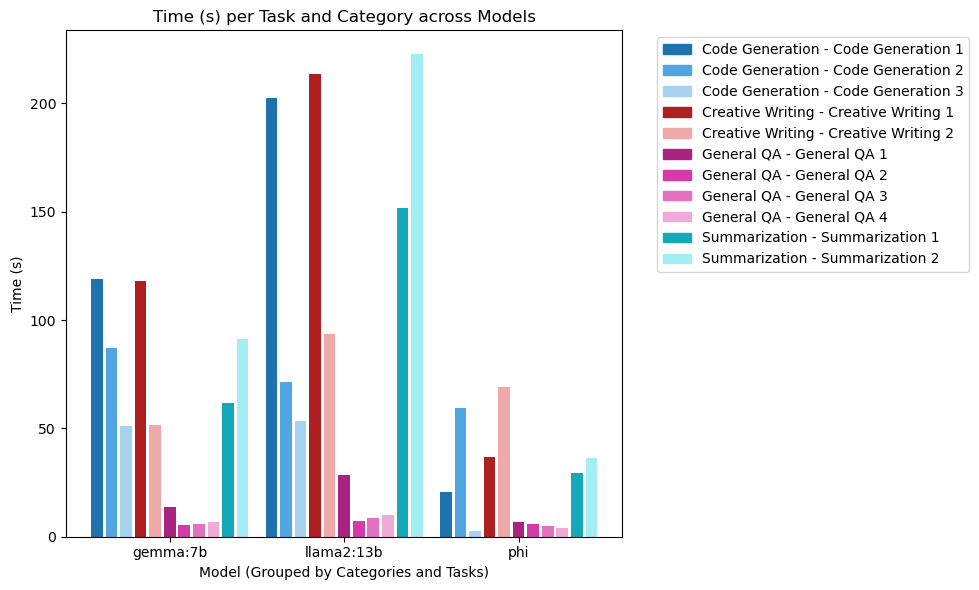

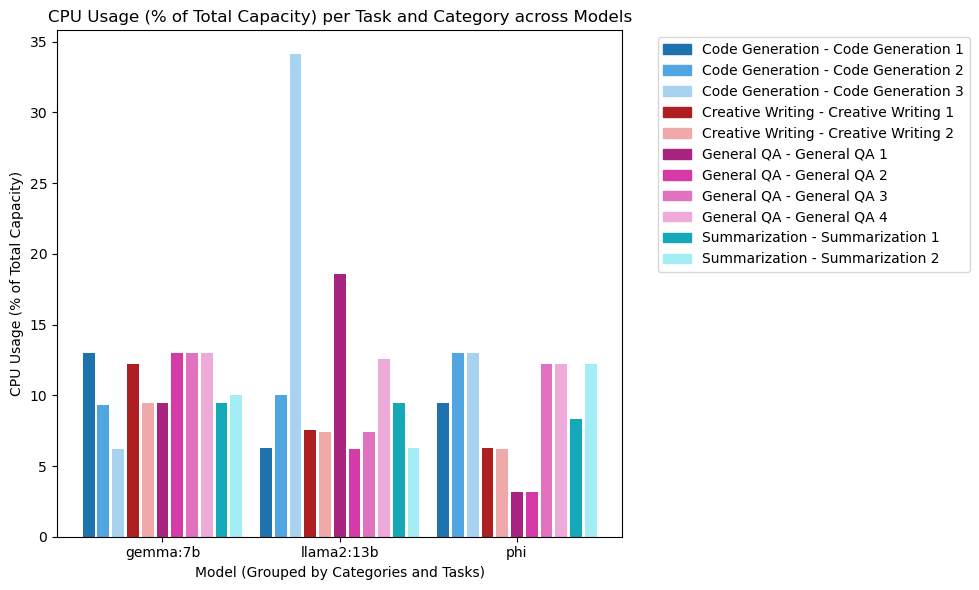

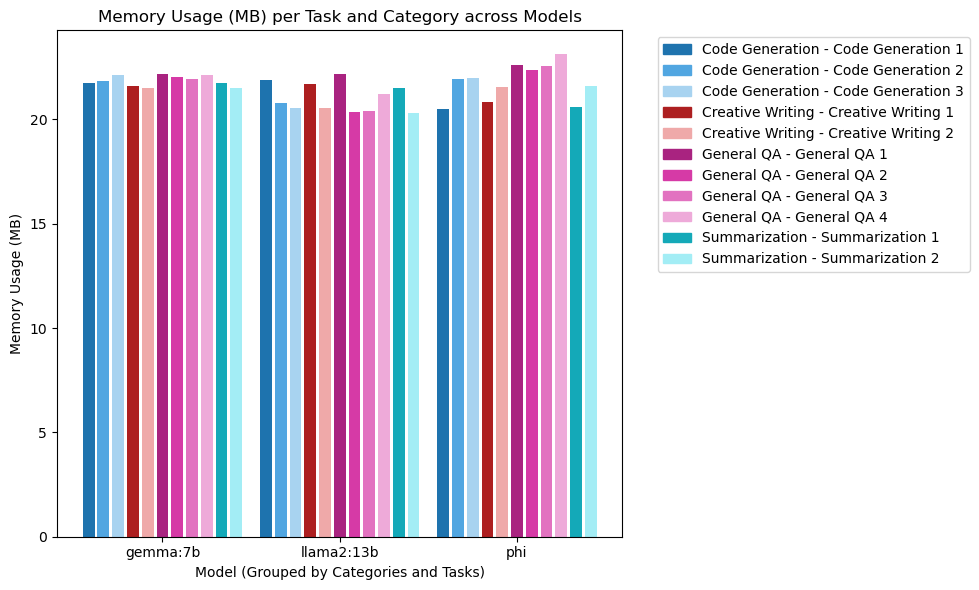

In [22]:
# -----------------------------------------------------------------------------
# PROCESSING DATA: Create a flat list of comparisons
# -----------------------------------------------------------------------------
comparison_data = []
logical_cpus = psutil.cpu_count(logical=True)

for model, categories in results.items():
    for category, tasks_data in categories.items():
        for task, data in tasks_data.items():
            raw_cpu = data.get("CPU Usage (%)", 0)
            normalized_cpu = raw_cpu / logical_cpus if logical_cpus else 0

            comparison_data.append({
                "Model": model,
                "Category": category,
                "Task": task,
                "Time (s)": round(data.get("Time (s)", 0), 2),
                "Memory Usage (MB)": round(data.get("Memory Usage (MB)", 0), 2),
                "CPU Usage (% of Total Capacity)": round(normalized_cpu, 3)
            })

df_comparison = pd.DataFrame(comparison_data)

# Print the table neatly using tabulate
print("\nPerformance Comparison Table:")
print(tabulate(df_comparison, headers='keys', tablefmt='psql', showindex=False))

# -----------------------------------------------------------------------------
# ASSIGN X POSITIONS: Group data by Model with a small gap between models.
# -----------------------------------------------------------------------------
# Sort by Model, then Category, then Task so that the x-axis order makes sense.
df_comparison = df_comparison.sort_values(by=["Model", "Category", "Task"]).reset_index(drop=True)
x_positions = []
models_x_ticks = {}
current_x = 0
prev_model = None

for idx, row in df_comparison.iterrows():
    model = row["Model"]
    if prev_model is not None and model != prev_model:
        # Add a gap between groups (models)
        current_x += 1  # gap value
    x_positions.append(current_x)
    models_x_ticks.setdefault(model, []).append(current_x)
    current_x += 1
    prev_model = model

df_comparison["x"] = x_positions

# -----------------------------------------------------------------------------
# ASSIGN COLORS: Define a distinct base color for each category and a different
# shade for each task within that category.
# -----------------------------------------------------------------------------
unique_categories = sorted(df_comparison["Category"].unique())
# Use a qualitative colormap (tab10) to assign each category a base color.
base_cmap = plt.cm.get_cmap("tab10", len(unique_categories))
category_base_colors = {cat: base_cmap(i) for i, cat in enumerate(unique_categories)}

# For each category, assign a unique color per task (consistent across models)
tasks_color = {}  # Structure: { category: { task: rgb_color } }

for cat in unique_categories:
    tasks_in_cat = sorted(df_comparison[df_comparison["Category"] == cat]["Task"].unique())
    tasks_color[cat] = {}
    n_tasks = len(tasks_in_cat)
    base_color = category_base_colors[cat]
    # Convert the base color (RGB tuple) to HLS
    r, g, b = to_rgb(base_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    # Choose a range of lightness values for the tasks
    l_min, l_max = 0.4, 0.8 
    for j, task in enumerate(tasks_in_cat):
        if n_tasks == 1:
            new_l = l
        else:
            new_l = l_min + (l_max - l_min) * j / (n_tasks - 1)
        # Convert back to RGB using the same hue and saturation
        new_rgb = colorsys.hls_to_rgb(h, new_l, s)
        tasks_color[cat][task] = new_rgb

# -----------------------------------------------------------------------------
# PLOTTING FUNCTION: Creates a bar chart for a given measurement column.
# -----------------------------------------------------------------------------
def plot_measurement(measurement_col, y_label):
    plt.figure(figsize=(10, 6))
    
    # For creating a custom legend without duplicates.
    legend_handles = {}
    
    # Plot each bar
    for idx, row in df_comparison.iterrows():
        x = row["x"]
        value = row[measurement_col]
        cat = row["Category"]
        task = row["Task"]
        color = tasks_color[cat][task]
        plt.bar(x, value, color=color)
        
        # Build the label for the legend as "Category - Task"
        label = f"{cat} - {task}"
        if label not in legend_handles:
            from matplotlib.patches import Patch
            legend_handles[label] = Patch(color=color, label=label)
    
    # Set x-ticks to appear in the middle of each model group.
    model_ticks = {}
    for model, positions in models_x_ticks.items():
        model_ticks[model] = np.mean(positions)
    plt.xticks(list(model_ticks.values()), list(model_ticks.keys()))
    
    plt.xlabel("Model (Grouped by Categories and Tasks)")
    plt.ylabel(y_label)
    plt.title(f"{y_label} per Task and Category across Models")
    plt.legend(handles=list(legend_handles.values()), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# CREATE CHARTS: Plot the charts for Time, CPU Usage, and Memory Usage.
# -----------------------------------------------------------------------------
plot_measurement("Time (s)", "Time (s)")
plot_measurement("CPU Usage (% of Total Capacity)", "CPU Usage (% of Total Capacity)")
plot_measurement("Memory Usage (MB)", "Memory Usage (MB)")


# Performance Comparison Summary

The table above compares the performance of three models—**phi**, **gemma:7b**, and **llama2:13b**—across four task categories: General QA, Summarization, Code Generation, and Creative Writing. The metrics include execution time (in seconds), memory usage (in MB), and CPU usage as a percentage of my machine’s total capacity.

---

## Key Observations

### 1. Task Complexity & Execution Time
- **General QA Tasks:**
  - **Simpler Tasks:** Generally, these questions are straightforward and require less processing, resulting in lower execution times (e.g., phi tasks range from ~4–7 seconds).
  - **Variability:** Some variability exists even within the same category (e.g., phi's General QA 3 & 4 use more CPU and complete faster compared to QA 1 & 2) due to minor differences in question complexity or internal processing routines.

- **Summarization Tasks:**
  - **Lengthy Texts:** Summarization prompts work with larger excerpts (from news articles or literature), naturally requiring more computational effort to process and condense the text.
  - **Longer Execution Times:** Times vary significantly—from around 29 seconds (phi, Summarization 1) to over 222 seconds (llama2:13b, Summarization 2). This reflects the additional work involved in understanding and generating coherent summaries.

- **Code Generation Tasks:**
  - **Structured Output Requirements:** Generating correct and syntactically precise code (like prime checking, recursive factorial, or string reversal functions) often involves iterative checking and logical processing.
  - **Moderate to High Time Range:** Execution times can vary widely depending on the complexity and the model’s internal optimizations (e.g., gemma:7b Code Generation 1 took 119.03 seconds, while phi’s Code Generation 3 took as little as 2.41 seconds).

- **Creative Writing Tasks:**
  - **Complex Generative Demands:** These tasks require the model to generate extensive and nuanced creative text (stories or poems), leading to higher computational demand and longer processing times.
  - **Extended Processing Time:** For example, llama2:13b’s Creative Writing tasks range from 93.38 to 213.62 seconds, reflecting the creativity and detail required.

### 2. CPU Usage Variability
- **Influence of Task Complexity:**
  - **Higher CPU Percentages:** More complex tasks tend to use a higher percentage of CPU resources. This is evident in some high-intensity tasks (e.g., llama2:13b Code Generation 3 with 34.1% CPU usage) where increased processing iterations or complex computations are required.
  - **Operational Differences:** Even within similar task categories, CPU utilization can vary based on how the internal algorithms are implemented. For instance, phi’s General QA tasks show variations in CPU usage (3.15% vs. 12.213%) despite similar task structures.

- **Model Architecture & Optimization:**
  - **Variation Across Models:** Differences between models (architecture, model size, and internal processing optimizations) result in varying CPU usage. A larger model like llama2:13b, with more parameters to process, may naturally demand a higher CPU percentage when tackling complex tasks compared to the more optimized or smaller-scale phi.

### 3. Memory Usage Uniformity
- **Consistent Memory Footprint:**
  - **Similar Memory Consumption:** Across all tasks and models, memory usage remains remarkably consistent (mostly between 20–23 MB). This consistency suggests:
    - **Preloaded Model Weights:** The majority of memory is used to store the model’s weights or parameters, which are loaded once irrespective of the specific task.
    - **System-Level Regulation:** My machine or the runtime environment may be enforcing a memory cap or optimizing allocations such that the operations do not dramatically vary in their memory needs.
    - **Task Nature:** The tasks (text-based processing and generation) do not inherently require very large dynamic memory allocations beyond the fixed model resources.

### 4. Influence of Machine and Other Processes on CPU Usage
- **System Resource Sharing:**
  - **Competing Processes:** CPU usage percentages can be impacted by other background processes or tasks running on my machine. Even if a task is inherently resource-intensive, if other processes are also demanding CPU cycles, the percentage used by the model’s task might fluctuate.
  - **Resource Allocation Policies:** The operating system’s scheduling and resource management may reassign CPU cycles depending on the overall load, meaning that the observed CPU usage is an interplay between the model’s demands and my system’s current state.

---

## Conclusion

- **Execution Time:** Heavily influenced by task complexity and the specific operations required. Tasks involving longer texts (summarization) or more creative processing (creative writing) naturally take more time than straightforward QA prompts.
  
- **CPU Usage:** Varies significantly by both the inherent computational requirements of the task and the efficiency of the model architecture. Complex and iterative tasks consume higher CPU resources, and external factors (like background processes) can further affect these figures.
  
- **Memory Usage:** Remains nearly constant across different tasks and models, suggesting that it is largely governed by the fixed size of the model’s parameters and possibly regulated by the machine’s operational constraints.
  
- **System Impact:** The overall machine performance and any concurrent applications or processes can influence CPU usage metrics, potentially altering the reported percentages during heavy multitasking scenarios.


# Part 2: Focused Experimentation

## Overview

The code is structured in two main sections:

1. **Definition of Translation Tasks:**  
   A dictionary named `translation_tasks` is defined with several entries. Each entry corresponds to a specific translation direction and includes:
   - A descriptive key (e.g., `"Translation English to Spanish"`, `"Translation German to English"`, etc.).
   - A text prompt that instructs the language model to translate a given block of text from one language to another.

2. **Iterating Over Models and Recording Outputs:**  
   The script then loops over a list of models (stored in the variable `models`). For each model, it:
   - Prints a header indicating the current model.
   - Initializes the corresponding nested structure in the `results` dictionary to store translation outputs.
   - Iterates over each translation task, prints the task name, and executes the translation using the function `run_model(model, prompt)`.
   - Captures the model’s output along with timing and memory usage data, and stores this information in the `results` dictionary.
   - Finally, it prints the translated output for inspection.

---

## Detailed Breakdown

### 1. Translation Tasks Dictionary

The `translation_tasks` dictionary contains several key-value pairs. Each task instructs the model to perform a specific translation:

__[Spanish/Enlgish ](https://practiceespanol.com/mi-casa/)__

- **Translation English to Spanish:**  
  **Prompt:**  
  > "Translate the following text into Spanish:  
  > My house is small but cozy. It has a large and bright living room where we have two large sofa and a grand piano. It also has three bedrooms, each with a window overlooking the garden. In the master bedroom, there is a big bed and a spacious closet. The other two bedrooms are smaller, but they are perfect for my children."
  
  **Example Translation:**
  > "Mi casa es pequeña pero acogedora. Dispone de un amplio y luminoso salón donde tenemos dos grandes sofás y un piano de cola. También tiene tres dormitorios, cada uno con una ventana que da al jardín. En el dormitorio principal, hay una cama grande y un armario espacioso. Los otros dos dormitorios son más pequeños, pero son perfectos para mis hijos."

- **Translation Spanish to English:**  
  **Prompt:**  
  > "Translate the following text into English:  
  > La casa también tiene tres baños. Uno está junto al dormitorio principal, y los otros dos están en el pasillo. Todos tienen duchas y lavabos limpios. La cocina es mi lugar favorito. Es amplia y luminosa, con una mesa para comer en el centro. Me encanta cocinar aquí y compartir comidas con mi familia."
  
  **Example Translation:**  
  > "The house also has three bathrooms. One is next to the master bedroom, and the other two are in the hallway. All have clean showers and sinks. The kitchen is my favorite place. It is spacious and bright, with a dining table in the center. I love to cook here and share meals with my family."

__[Germain/Enlgish ](http://onlinegermanclub.com/german-english-parallel-texts/)__

- **Translation German to English:**  
  **Prompt:**  
  > "Translate the following text into English:  
  > Kerstin ist 25 Jahre alt. Sie studiert Medizin in Frankfurt und hat viele Freunde, weil sie sympatisch und freundlich ist. Sie geht mit einem jungen Mann aus, der Robert heisst. Er ist 30 Jahre alt und arbeitet in Stuttgart: er ist ein Ingenieur. Robert geht gerne am Abend aus, geht ins Kino, und trifft sich mit seinen Freunden. Kerstin und Robert sind seit drei Jahren verlobt. Sie wohnen in verschiedenen Städten, aber zum Glück sind Frankfurt und Stuttgart nicht sehr weit entfernt. Kerstin hat die Wohnungsschlüssel von Robert und Robert hat die Schlüssel von Kerstin: die beiden haben keine Geheimnisse. Heute ist Mittwoch. Kerstin hat keine Vorlesung in der Universität. Sie möchte Robert eine Überraschung bereiten, weil heute ein besonderer Tag ist. Für Kerstin ist es tatsächlich ein sehr wichtiger Tag."
  
  **Example Translation:**  
  > "Kerstin is 25 years old. She is studying medicine at Frankfurt. She has lots of friends because she is likable and kind. She is going out with a young man called Robert. He is 30 years old and works at Stuttgart, as an engineer. Robert loves going out in the evenings, to the cinema or to meet friends. Kerstin and Robert have been engaged for three years. They live in different cities but luckily Frankfurt and Stuttgart are not very far apart. Kerstin has the keys to Robert’s house and Robert has those of Kerstin’s. The two young people don’t have any secrets. Today is Wednesday. Kerstin has no lessons at the university. She wants to give Robert a surprise because today is a special day. For Kerstin, in fact it is a very important day."

- **Translation English to German:**  
  **Prompt:**  
  > "Translate the following text into German:  
  > Today is May 15. It’s the anniversary of Kerstin and David’s engagement. Kerstin wants to give Robert a surprise: to go to his place at Stuttgart to celebrate this special day together. She knows Robert works until 17.00 so she goes to the station at Frankfurt to catch the 16.18 train. The timing is perfect. At the station there is a big clock in the square and inside is the ticket office. Trains go to every part of Germany so the station is very crowded. Kerstin goes to platform 4 and boards the train for Stuttgart. Unfortunately the train is ten minutes late leaving, but Kerstin arrives at Stuttgart at 17.00, just in time! It’s already 17.30 when she arrives at Robert’s house. “Robert is sure to be home,” thinks Kerstin. She rings the bell and waits, but no one opens the door. Robert isn’t there."
  
  **Example Translation:**  
  > "Heute ist der 15. Mai. Es ist der Jahrestag der Verlobung von Kerstin und Robert. Kerstin möchte Robert eine Überraschung bereiten: sie will zu ihm nach Hause nach Stuttgart fahren, um zusammen diesen besonderen Tag zu feiern. Sie weiss, dass Robert bis 17 Uhr in der Arbeit ist, deshalb geht sie zum Bahnhof von Frankfurt, um den Zug um 16:18 zu nehmen. Die Uhrzeiten sind perfekt! Am Bahnhof ist auf dem Platz die große Uhr und im Inneren ist der Fahrkartenschalter. Die Züge fahren in alle Richtungen und deshalb ist der Bahnhof sehr überfüllt. Kerstin geht zu Gleis 4 und steigt in den Zug nach Stuttgart. Leider fährt der Zug mit 10 Minuten Verspätung ab, aber Kerstin kommt in Stuttgart genau rechtzeitig um 17 Uhr an! Als sie zu Hause bei Robert ankommt ist es schon halb sechs. “Sicher ist Robert schon zu Hause” denkt Kerstin, also läutet sie die Türklingel und wartet, aber niemand öffnet die Tür. Robert ist nicht da."

__[French/Enlgish ](http://onlinefrenchclub.com/french-english-parallel-texts/)__

- **Translation French to English:**  
  **Prompt:**  
  > "Translate the following text into English:  
  > Élise a 25 ans. Elle étudie la médecine à Brest et elle a beaucoup d’amis car elle est gentille et sympathique. Elle sort avec un garçon qui s’appelle Julien. Lui, il a 30 ans et il travaille à Rennes : il est ingénieur. Julien adore sortir le soir, aller au cinéma et rencontrer ses amis. Élise et Julien sont ensemble depuis trois ans. Ils habitent dans deux villes différentes, mais heureusement Brest et Rennes ne sont pas très loin. Élise a les clés de l’appartement de Julien, et Julien a les clés d’Élise : le couple n’a pas de secrets. Aujourd’hui c’est mercredi. Élise n’a pas cours à l’université. Elle veut faire une surprise à Julien parce qu’aujourd’hui est un jour spécial. Pour Élise en effet c’est un jour très important."
  
  **Example Translation:**  
  > "Élise is 25 years old. She is studying medicine in Brest and has lots of friends because she is nice and kind. She is going out with a boy called Julien. He is 30 years old and works in Rennes: he is an engineer. Julien loves going out in the evenings, going to the cinema and meeting his friends. Élise and Julien have been together for three years. They live in different cities but luckily Brest and Rennes are not very far apart. Élise has the keys to Julien’s house and Julien has the keys to Élise’s house: they don’t have any secrets. Today is Wednesday. Élise doesn’t have lessons at the university. She wants to surprise Julien because today is a special day. For Élise, in fact, it is a very important day."

- **Translation English to French:**  
  **Prompt:**  
  > "Translate the following text into French:  
  > Today is May 15th. It’s the anniversary of when Élise and Julien got together. Élise wants to surprise Julien: she is going to go to Julien’s place in Rennes so they can celebrate this special day together. She knows Julien works until 5 o’clock, so she goes to the train station in Brest to catch the 4.18pm train. The train times are perfect! At the station there is a big clock tower, and inside is the ticket office. Trains leave from here and travel all over France, so the station is very crowded. Élise goes to platform 4 and boards the train to Rennes. Unfortunately the train leaves ten minutes late, but Élise arrives in Rennes at 5 o’clock. Just in time! When she gets to Julien’s house it’s half past five already. “Julien is sure to be home,” thinks Élise, so she rings the bell and waits, but no one opens the door. Julien is not at home."
  
  **Example Translation:**  
  > "Aujourd’hui c’est le 15 mai. C’est le jour où Élise et Julien se sont mis ensemble. Élise veut faire une surprise à Julien : aller chez lui à Rennes pour fêter ensemble ce jour spécial. Elle sait que Julien est au travail jusqu’à 17h, donc elle va à la gare de Brest pour prendre le train de 16h18. L’horaire est parfait ! À la gare il y a la grande tour de l’horloge et la billetterie à l’intérieur. Les trains vont dans toute la France donc il y a beaucoup de monde dans la gare. Élise va au quai 4 et monte dans le train pour Rennes. Malheureusement le train part avec dix minutes de retard, mais Élise arrive à Rennes à 17h : juste à temps ! Quand elle arrive chez Julien il est déjà 17h30. “Julien sera sûrement déjà à la maison” pense Élise, alors elle sonne à la porte et attend, mais personne n’ouvre : Julien n’est pas chez lui."


In [24]:
# ---- Updated Translation Tasks ----
translation_tasks = {
    "Translation English to Spanish": (
        "Translate the following text into Spanish:\n"
        "My house is small but cozy. It has a large and bright living room where we have two large sofa and a grand piano. "
        "It also has three bedrooms, each with a window overlooking the garden. In the master bedroom, there is a big bed and a spacious closet. "
        "The other two bedrooms are smaller, but they are perfect for my children."
    ),
    "Translation Spanish to English": (
        "Translate the following text into English:\n"
        "La casa también tiene tres baños. Uno está junto al dormitorio principal, y los otros dos están en el pasillo. "
        "Todos tienen duchas y lavabos limpios. La cocina es mi lugar favorito. Es amplia y luminosa, con una mesa para comer en el centro. "
        "Me encanta cocinar aquí y compartir comidas con mi familia."
    ),
    "Translation German to English": (
        "Translate the following text into English:\n"
        "Kerstin ist 25 Jahre alt. Sie studiert Medizin in Frankfurt und hat viele Freunde, weil sie sympatisch und freundlich ist. "
        "Sie geht mit einem jungen Mann aus, der Robert heisst. Er ist 30 Jahre alt und arbeitet in Stuttgart: er ist ein Ingenieur. "
        "Robert geht gerne am Abend aus, geht ins Kino, und trifft sich mit seinen Freunden. Kerstin und Robert sind seit drei Jahren verlobt. "
        "Sie wohnen in verschiedenen Städten, aber zum Glück sind Frankfurt und Stuttgart nicht sehr weit entfernt. "
        "Kerstin hat die Wohnungsschlüssel von Robert und Robert hat die Schlüssel von Kerstin: die beiden haben keine Geheimnisse. "
        "Heute ist Mittwoch. Kerstin hat keine Vorlesung in der Universität. Sie möchte Robert eine Überraschung bereiten, weil heute ein besonderer Tag ist. "
        "Für Kerstin ist es tatsächlich ein sehr wichtiger Tag."
    ),
    "Translation English to German": (
        "Translate the following text into German:\n"
        "Today is May 15. It’s the anniversary of Kerstin and David’s engagement. Kerstin wants to give Robert a surprise: "
        "to go to his place at Stuttgart to celebrate this special day together. She knows Robert works until 17.00 so she goes to the station at Frankfurt to catch the 16.18 train. "
        "The timing is perfect. At the station there is a big clock in the square and inside is the ticket office. "
        "Trains go to every part of Germany so the station is very crowded. Kerstin goes to platform 4 and boards the train for Stuttgart. "
        "Unfortunately the train is ten minutes late leaving, but Kerstin arrives at Stuttgart at 17.00, just in time! "
        "It’s already 17.30 when she arrives at Robert’s house. “Robert is sure to be home,” thinks Kerstin. "
        "She rings the bell and waits, but no one opens the door. Robert isn’t there."
    ),
    "Translation French to English": (
        "Translate the following text into English:\n"
        "Élise a 25 ans. Elle étudie la médecine à Brest et elle a beaucoup d’amis car elle est gentille et sympathique. "
        "Elle sort avec un garçon qui s’appelle Julien. Lui, il a 30 ans et il travaille à Rennes : il est ingénieur. "
        "Julien adore sortir le soir, aller au cinéma et rencontrer ses amis. Élise et Julien sont ensemble depuis trois ans. "
        "Ils habitent dans deux villes différentes, mais heureusement Brest et Rennes ne sont pas très loin. "
        "Élise a les clés de l’appartement de Julien, et Julien a les clés d’Élise : le couple n’a pas de secrets. "
        "Aujourd’hui c’est mercredi. Élise n’a pas cours à l’université. Elle veut faire une surprise à Julien parce qu’aujourd’hui est un jour spécial. "
        "Pour Élise en effet c’est un jour très important."
    ),
    "Translation English to French": (
        "Translate the following text into French:\n"
        "Today is May 15th. It’s the anniversary of when Élise and Julien got together. Élise wants to surprise Julien: "
        "she is going to go to Julien’s place in Rennes so they can celebrate this special day together. "
        "She knows Julien works until 5 o’clock, so she goes to the train station in Brest to catch the 4.18pm train. "
        "The train times are perfect! At the station there is a big clock tower, and inside is the ticket office. "
        "Trains leave from here and travel all over France, so the station is very crowded. Élise goes to platform 4 and boards the train to Rennes. "
        "Unfortunately the train leaves ten minutes late, but Élise arrives in Rennes at 5 o’clock. Just in time! "
        "When she gets to Julien’s house it’s half past five already. “Julien is sure to be home,” thinks Élise, so she rings the bell and waits, but no one opens the door. "
        "Julien is not at home."
    )
}

# ---- Translation Tasks Loop ----
for model in models:
    print(f"\n=== Running Translation tasks for model: {model} ===")
    
    if model not in results:
        results[model] = {}
    if "Translation" not in results[model]:
        results[model]["Translation"] = {}
    
    for task_name, prompt in translation_tasks.items():
        print(f"\nTask: {task_name}")
        output_data = run_model(model, prompt)
        results[model]["Translation"][task_name] = {
            "Prompt": prompt,
            "Output": output_data["output"],
            "Time (s)": output_data["time"],
            "Memory Usage (MB)": output_data["mem_usage_MB"]
        }
        print("Output:\n", output_data["output"])



=== Running Translation tasks for model: phi ===

Task: Translation English to Spanish
Output:
  La casa es pequeña pero cómoda. Tiene una sala grande y llena de luz en el que tenemos dos sofas grandes y un piano grande. También tiene tres habitaciones, todas con ventana al jardín. En la habitación del hogar médico, hay una banca enorme y un espacio largo. Los otro dos habitaciones son menos grandes, pero es perfectamente suficiente para mi hijo(a). 

Translation: My house is small but cozy. It has a large and bright living room where we have two big sofas and a grand piano. It also has three bedrooms, each with a window overlooking the garden. In the master bedroom, there is a big bed and a spacious closet. The other two bedrooms are smaller, but they are perfect for my son(s).


Consider the following situation: 

There are four rooms in your house: living room (L), dining room (D), bedrooms (B) and bathroom (S). Each room has unique characteristics which we know from the conversati

# Analysis and Comparison of Model Responses - Language Translation
- **Phi’s Extended Response (English to Spanish):**  
  - **Issue:** Rather than solely providing a translation, Phi appended a deductive reasoning puzzle involving a room arrangement.  
  - **Why It Happened:** It appears that Phi misinterpreted the extensive context given in the prompt breakdown  as an instruction to provide additional reasoning. This resulted in an overly extended output that both detracted from the primary translation task and introduced inaccuracies.
  
- **Model Consistency:**  
  - **Gemma:7b** generally produces fluent translations that are mostly accurate. Its minor mistakes (such as vocabulary slips or inconsistent names) are less severe than the more significant errors seen in Phi’s outputs.  
  - **Llama2:13b** performs well in several tasks, though it sometimes falls into minor code-switching or stylistic inconsistencies, particularly with the English-to-French task.
  
- **Task-Specific Issues:**  
  - The **English-to-German** task highlights the greatest disparity among models. Phi’s output is largely unusable, while Gemma and Llama2, though not perfect, are considerably clearer.
  - The **English-to-French** task also shows a stark contrast: Phi’s refusal stands out as the worst performance, whereas Gemma and Llama2 attempt the translation with varying levels of coherence.

---

## Conclusion

- **Phi’s Performance:**  
  - Shows a tendency to overextend its responses by incorporating extra content (such as the room arrangement puzzle in the English-to-Spanish task) and is inconsistent—especially in the English-to-German and English-to-French translations.
  
- **Gemma:7b’s Performance:**  
  - Offers consistently fluent and mostly accurate translations across tasks. Minor vocabulary or naming issues are present but do not severely impact clarity.
  
- **Llama2:13b’s Performance:**  
  - Generally produces acceptable translations with good adherence to the original meaning. However, code-switching and stylistic inconsistencies occasionally undermine the output quality.

Overall, for tasks requiring both accuracy and adherence to the prompt, Gemma:7b tends to perform best, while Phi struggles—especially when extra contextual material causes it to deviate from the expected response format.
